In [1]:
import numpy as np

class State:
    def __init__(self, vehicle_length, position, heading_angle, steering_angle, position_bounds=[[None, None], [None, None]], ang_bounds=[None, None], st_ang_bounds=[None, None]):
        self.position       = position  # Center of front axle [x, y]
        self.heading_angle  = heading_angle
        self.steering_angle = steering_angle

        self.position_bounds = position_bounds
        self.ang_bounds = ang_bounds
        self.st_ang_bounds = st_ang_bounds

        self.vehicle_length = vehicle_length

    @staticmethod
    def fromRawState(arr):
        return State(0, [arr[0], arr[1]], arr[2], arr[3])
        
    def update(self, velocity, steering_rate, dT):
        """,
        [x, y, 𝜃, 𝛿], 𝜃 is heading angle, 𝛿 is steering angle. Our inputs are [𝑣, 𝜑], 𝑣 is velocity, 𝜑 is steering rate.

        x_dot = v * cos(𝛿 + 𝜃)
        y_dot = v * sin(𝛿 + 𝜃)
        𝜃_dot = v / R = v / (L/sin(𝛿)) = v * sin(𝛿)/L
        𝛿_dot = 𝜑
        """

        self.steering_angle += steering_rate * dT
        heading_dot = velocity * np.sin(self.steering_angle) / self.vehicle_length
        self.heading_angle += heading_dot * dT
        x_dot = velocity * np.cos(self.heading_angle + self.steering_angle)
        y_dot = velocity * np.sin(self.heading_angle + self.steering_angle)

        self.position[0] += x_dot * dT
        self.position[1] += y_dot * dT

        # Enforce constraints
        if self.position_bounds[0][0] is not None:
            self.position[0] = max(self.position_bounds[0][0], self.position[0])
        if self.position_bounds[0][1] is not None:
            self.position[0] = min(self.position_bounds[0][1], self.position[0])
        if self.position_bounds[1][0] is not None:
            self.position[1] = max(self.position_bounds[1][0], self.position[1])
        if self.position_bounds[1][1] is not None:
            self.position[1] = min(self.position_bounds[1][1], self.position[1])

        if self.ang_bounds[0] is not None:
            self.heading_angle = max(self.ang_bounds[0], self.heading_angle)
        if self.ang_bounds[1] is not None:
            self.heading_angle = min(self.ang_bounds[1], self.heading_angle)

        if self.st_ang_bounds[0] is not None:
            self.steering_angle = max(self.st_ang_bounds[0], self.steering_angle)
        if self.st_ang_bounds[1] is not None:
            self.steering_angle = min(self.st_ang_bounds[1], self.steering_angle)

    def copy(self):
        return State(self.vehicle_length, self.position.copy(), self.heading_angle, self.steering_angle, self.position_bounds, self.ang_bounds, self.st_ang_bounds)

    def updated_state(self, actions, dT):
        actions = np.reshape(actions, (-1, 2))
        new_state = self.copy()
        for i in actions:
            new_state.update(i[0], i[1], dT)

        return new_state

    def raw_state(self):
        return [self.position[0], self.position[1], self.heading_angle, self.steering_angle]

    def check_bounds(self):
        if self.position_bounds[0][0] is not None and self.position[0] < self.position_bounds[0][0]:
            return False
        if self.position_bounds[0][1] is not None and self.position[0] > self.position_bounds[0][1]:
            return False
        if self.position_bounds[1][0] is not None and self.position[1] < self.position_bounds[1][0]:
            return False
        if self.position_bounds[1][1] is not None and self.position[1] > self.position_bounds[1][1]:
            return False
        
        if self.ang_bounds[0] is not None and self.heading_angle < self.ang_bounds[0]:
            return False
        if self.ang_bounds[1] is not None and self.heading_angle > self.ang_bounds[1]:
            return False
        
        if self.st_ang_bounds[0] is not None and self.steering_angle < self.st_ang_bounds[0]:
            return False
        if self.st_ang_bounds[1] is not None and self.steering_angle > self.st_ang_bounds[1]:
            return False
        
        return True

    def check_obstacles(self, obstacles):
        for obstacle in obstacles:
            distance = ((self.position[0] - obstacle[0])**2 + (self.position[1] - obstacle[1])**2)**.5
            if distance < obstacle[2]:
                return 1

        return 0

In [2]:
from scipy.optimize import minimize, NonlinearConstraint

class Optimizer:
    def __init__(self, initial_state, waypoints, dT, N, per_state_cost_function, final_state_cost_function, goal, obstacles, input_bounds, additional_constraints=lambda x: 0):
        self.state = initial_state
        self.waypoints = waypoints
        self.state_cost = per_state_cost_function
        self.fstate_cost = final_state_cost_function
        self.obstacles = obstacles
        self.goal = goal
        self.dT = dT
        self.additional_constraints = additional_constraints
        self.input_bounds = input_bounds
        self.N = N

    def cost(self, x):
        waypoint_weight = 1
        goal_weight = .1

        x = np.reshape(x, (self.N, 2))
        through_waypoint = float('inf')

        state = self.state.copy()

        dist_to_waypoint = ((state.position[0] - self.waypoints[0].position[0])**2 + (state.position[1] - self.waypoints[0].position[1])**2)**.5
        if dist_to_waypoint < through_waypoint:
            through_waypoint = dist_to_waypoint

        cost = 0

        for i in x:
            # if i[0] < 0:
            #    cost += 10 * i[0]

            state.update(i[0], i[1], self.dT)

            dist_to_waypoint = ((state.position[0] - self.waypoints[0].position[0])**2 + (state.position[1] - self.waypoints[0].position[1])**2)**.5
            if dist_to_waypoint < through_waypoint:
                through_waypoint = dist_to_waypoint

            for obstacle in self.obstacles:
                distance = ((state.position[0] - obstacle[0])**2 + (state.position[1] - obstacle[1])**2)**.5
                if distance < obstacle[2]:
                    cost += 10000000 * obstacle[2]/distance

        distance_to_goal = ((state.position[0] - self.goal.position[0])**2 + (state.position[1] - self.goal.position[1])**2)**.5
        cost += distance_to_goal * goal_weight
        cost += through_waypoint * waypoint_weight

            # cost += .2 * self.state_cost(state, self.obstacles, self.goal)
            # cost += 1 * self.state_cost(state, [], self.waypoints[0])
            
        # cost += .2 * self.state_cost(state, self.obstacles, self.goal) + self.fstate_cost(state, self.goal)
        # cost += 1 * self.state_cost(state, [], self.waypoints[0]) + .2 * self.fstate_cost(state, self.waypoints[0])

        return cost

    # def constraints(self, x):
    #     state = self.state.copy()
    #     x = np.reshape(x, (-1, 2))

    #     cost = 0
    #     for i in x:
    #         state.update(i[0], i[1], self.dT)
    #         cost += (not state.check_bounds() * 1)
    #         cost += state.check_obstacles(self.obstacles)

    #     return cost

    def calculate_optimal_input(self, initial_guess, N):
        # N actions
        # N+1 states
        # actions = np.array( [initial_guess for _ in range(N)] )
        actions = np.array(initial_guess)
        # actions = actions.flatten()

        bounds = []

        for _ in range(N):
            bounds.extend(self.input_bounds)
        
        # Minimize the cost function
        result = minimize(self.cost, actions, bounds=bounds)
        
        optimal_inputs = result.x
        return optimal_inputs

    

In [3]:
def dist(a: State, b):
    return ((a.position[0] - b[0])**2 + (a.position[1] - b[1])**2)**.5

def per_state_cost_function(state: State, obstacles, goal: State):
    cost = 0

    # Add cost for distance to goal
    x_dist = (goal.position[0] - state.position[0]) ** 2
    y_dist = (goal.position[1] - state.position[1]) ** 2

    cost += (x_dist + y_dist) ** .5

    # Add cost for bounds
    if state.position_bounds[0][0] is not None and state.position[0] < state.position_bounds[0][0]:
        cost += 100 * state.position_bounds[0][0] - state.position[0]
    if state.position_bounds[0][1] is not None and state.position[0] > state.position_bounds[0][1]:
        cost += 100 * state.position[0] - state.position_bounds[0][1]
    if state.position_bounds[1][0] is not None and state.position[1] < state.position_bounds[1][0]:
        cost += 100 * state.position_bounds[1][0] - state.position[1]
    if state.position_bounds[1][1] is not None and state.position[1] > state.position_bounds[1][1]:
        cost += 100 * state.position[1] - state.position_bounds[1][1]

    if state.ang_bounds[0] is not None and state.heading_angle < state.ang_bounds[0]:
        cost += 100 * state.ang_bounds[0] - state.heading_angle
    if state.ang_bounds[1] is not None and state.heading_angle > state.ang_bounds[1]:
        cost += 100 * state.heading_angle - state.ang_bounds[1]

    if state.st_ang_bounds[0] is not None and state.steering_angle < state.st_ang_bounds[0]:
        cost += 100 * state.st_ang_bounds[0] - state.steering_angle
    if state.st_ang_bounds[1] is not None and state.steering_angle > state.st_ang_bounds[1]:
        cost += 100 * state.steering_angle - state.st_ang_bounds[1]

    for obstacle in obstacles:
        distance = dist(state, obstacle)
        if distance <= obstacle[2]:
            cost += 10000000 * obstacle[2]/distance

    return cost

def final_state_cost_function(state, goal):
    cost = 0

    # Add cost for distance to goal
    x_dist = (goal.position[0] - state.position[0]) ** 2
    y_dist = (goal.position[1] - state.position[1]) ** 2

    cost += x_dist
    cost += y_dist
    
    # if goal.velx is not None:
    #     vx_dist = (goal.velx - state.velx) ** 2
    # else:
    #     vx_dist = 0

    # if goal.vely is not None:
    #     vy_dist = (goal.vely - state.vely) ** 2
    # else:
    #     vy_dist = 0

    return cost * 1000
    

In [39]:
# initial_state = State(0, 0, 0, 0, velx_bounds=(-5, 5), vely_bounds=(-5, 5))
# goal_state = State(5, 10, 0, 0, velx_bounds=(-5, 5), vely_bounds=(-5, 5))

# obstacles = [[2.5, 7.5, 1], [5.0, 3.0, 1], [3.0, 3.0, 1], [7.5, 7.5, 1]]
# waypoints = [[2, 5, None, None], [4, 6, None, None], [goal_state.x, goal_state.y, goal_state.velx, goal_state.vely]]
# dT = .1
# N = 30

# optimizer = Optimizer(initial_state, [], dT, per_state_cost_function, final_state_cost_function, goal_state, obstacles, (-3, 3))
# optimal_inputs = optimizer.calculate_optimal_input([2/dT/N, 5/dT/N], N)

initial_state = State(1, [0, 0], 0, 0, position_bounds=[[-10, 10], [-10, 10]], ang_bounds=[None, None], st_ang_bounds=[-np.pi/2, np.pi/2])
goal_state = State(1, [5, 5], None, None, position_bounds=[[-10, 10], [-10, 10]], ang_bounds=[None, None], st_ang_bounds=[-np.pi/2, np.pi/2])

obstacles = [[2, 2.5, 1], [3, 1, 1], [3.5, 3.5, 1], [2.5, 4.5, 1]]
waypoints = [[1.5, 4, None, None], [1.2, 5, None, None], [3, 6, None, None], [4, 5, None, None], [goal_state.position[0], goal_state.position[1], None, None]]

# waypoints = [[goal_state.position[0], goal_state.position[1], None, None]]

dT = .1
N = 10

# optimizer = Optimizer(initial_state, waypoints, dT, per_state_cost_function, final_state_cost_function, goal_state, obstacles, [[-3, 3], [-np.pi/4, np.pi/4]])
# optimal_inputs = optimizer.calculate_optimal_input([2/dT/N, 0], N)

In [43]:
import numpy as np
import time

time_spent = 0
iters_spent = 0

range_ = .5

total_inputs = []
rest_of_them = []
state = initial_state.copy()

def within_range(state, waypoint):
    dist_ = ((waypoint[0] - state.position[0])**2 + (waypoint[1] - state.position[1])**2)**.5

    return dist_ <= range_

waypoints_copy = waypoints.copy()

while len(waypoints_copy) > 0:
    start_time = time.time()
    optimizer = Optimizer(state.copy(), [State.fromRawState(way) for way in waypoints_copy], dT, N, per_state_cost_function, final_state_cost_function, goal_state, obstacles, [[-2, 3], [-np.pi/3, np.pi/3]])
    # optimal_inputs = optimizer.calculate_optimal_input([2/dT/N, 0], N)

    # print("INITIAL INPUT: ", [current_to_waypoint_needed_velocity, current_to_waypoint_needed_steering_angle])

    starting_inputs = []

    if len(rest_of_them) > 0:
        starting_inputs = list(rest_of_them)

        emulated_state = state.updated_state(starting_inputs, dT)

        current_to_waypoint_vector = np.array([waypoints_copy[0][0] - emulated_state.position[0], waypoints_copy[0][1] - emulated_state.position[1]])

        current_to_waypoint_needed_velocity = np.linalg.norm(current_to_waypoint_vector) / dT / N
        current_to_waypoint_needed_steering_angle = (np.arctan2(current_to_waypoint_vector[1], current_to_waypoint_vector[0]) - emulated_state.heading_angle) / dT / N

        for _ in range(N - int(len(rest_of_them) / 2)):
            # starting_inputs.extend([total_inputs[-2], 0])
            starting_inputs.extend([current_to_waypoint_needed_velocity, current_to_waypoint_needed_steering_angle])
    else:
        # Set initial velocity and angle based on next waypoint
        current_to_waypoint_vector = np.array([waypoints_copy[0][0] - state.position[0], waypoints_copy[0][1] - state.position[1]])

        current_to_waypoint_needed_velocity = np.linalg.norm(current_to_waypoint_vector) / dT / N
        current_to_waypoint_needed_steering_angle = (np.arctan2(current_to_waypoint_vector[1], current_to_waypoint_vector[0]) - state.heading_angle) / dT / N

        for _ in range(N):
            starting_inputs.extend([current_to_waypoint_needed_velocity, current_to_waypoint_needed_steering_angle])

    optimal = optimizer.calculate_optimal_input(
        starting_inputs,
        N
    )

    optimal_inputs = optimal[:8]
    rest_of_them = optimal[8:]

    # time.sleep(2)
    # optimal_inputs = optimizer.calculate_optimal_input(
    #     [0, 0],
    #     N
    # )[:16]
    end_time = time.time()

    time_spent += end_time - start_time
    iters_spent += 1

    total_inputs.extend(optimal_inputs)
    state = state.updated_state(optimal_inputs, dT)

    # print(state.raw_state())

    if within_range(state, waypoints_copy[0]):
        # print("WITHIN RANGE")
        if within_range(state, waypoints_copy[-1]):
            break
        waypoints_copy.pop(0)

print(total_inputs)
print("FINAL STATE: ", state.raw_state())
print("AVG TIME: ", time_spent / iters_spent)

[3.0, 0.970976078608393, 3.0, 0.9444213132616176, 3.0, 0.9266756370337224, 3.0, 0.9178708134848019, 3.0, 0.9178897142475175, 3.0, 0.9262859256884118, 3.0, 0.9421991379992479, 3.0, 0.9642896726484653, 2.984470621940305, 0.8529682627684749, 2.9623149362539207, 0.9235329561246017, 2.0176342215935743, -0.1330072744210105, 2.0184866374346675, -0.10830736274792128, -2.0, -1.0471975511965976, -2.0, -1.0471975511965976, -2.0, -1.0471975511965976, -1.1769755695867974, -1.0471975511965976, 2.361694729729284, -1.046885755119072, 2.9714596057744482, -1.0468665843507898, 2.9754881442029957, -1.0469021081494247, 2.979510857414726, -1.0469396283777337, 2.999999993690294, -1.0469788749472677, 2.999996629037884, -1.0470167650158013, 1.989617692491181, -0.9326203479973755, 2.040046219188166, -0.862335119160915, 2.684561340849903, 0.9789043459197965, 2.8443724873165976, 0.9439449222178122, 0.22357623819960318, -0.11040524822884878, -0.11780085804006728, 0.4006183920727433, -0.2864828019304648, 0.90252370

[[0, 0, 0, 0], [0.2976149150445223, 0.037753971222134856, 0.029083532382468663, 0.0970976078608393], [0.5861186330963477, 0.12000726702402259, 0.08619474265507104, 0.19153973918700107], [0.8556600563423418, 0.2517168762198738, 0.17031373526149535, 0.2842073028903733], [1.093306013086652, 0.4348135699177158, 0.2804730242500346, 0.3759943842388535], [1.2836341760419059, 0.6667083529251788, 0.41574568962111924, 0.4677833556636053], [1.4101057581746377, 0.9387468408507731, 0.575206243046595, 0.5604119482324464], [1.4573970866745787, 1.2349959425349988, 0.7578664183481554, 0.6546318620323712], [1.4146861170862992, 1.5319399996852119, 0.96259079034483, 0.7510608292972177], [1.2849628695877249, 1.8007197012823957, 1.1841003058611914, 0.8363576555740653], [1.0767870416051624, 2.0114705552766448, 1.421336894036286, 0.9287109511865255], [0.9155439820709539, 2.132751857518593, 1.5812974916187914, 0.9154102237444244], [0.738118413150708, 2.22899660048334, 1.7399839151612975, 0.9045794874696322], [

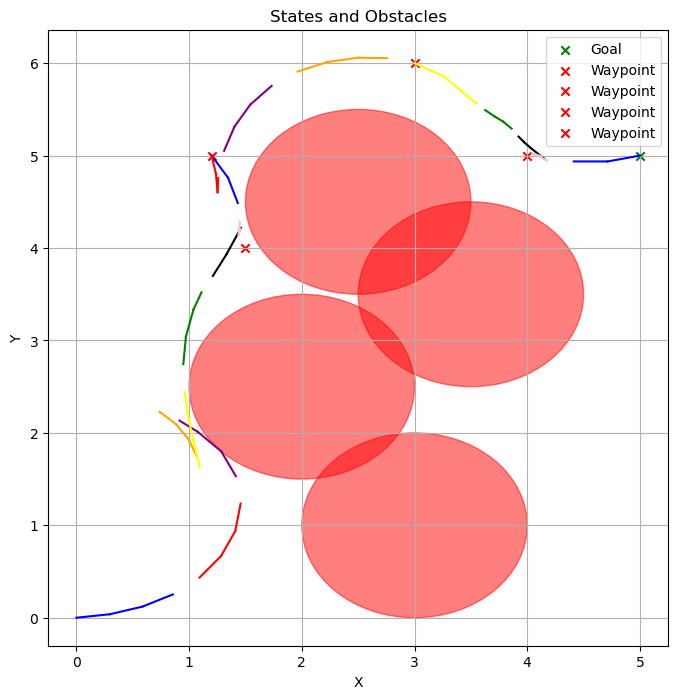

In [41]:
import matplotlib.pyplot as plt

# Calculate optimal inputs
new_actions = np.reshape(total_inputs, (-1, 2))

# current_to_waypoint_needed_velocity = np.linalg.norm(current_to_waypoint_vector) / dT / N
# current_to_waypoint_needed_steering_angle = np.arctan2(current_to_waypoint_vector[1], current_to_waypoint_vector[0]) / dT / N

# new_actions = np.reshape([3.18688719599549, 1.373400766945016, 3.18688719599549, 1.373400766945016, 3.18688719599549, 1.373400766945016, 3.18688719599549, 1.373400766945016, 3.18688719599549, 1.373400766945016, 3.18688719599549, 1.373400766945016, 3.18688719599549, 1.373400766945016, 3.18688719599549, 1.373400766945016, 3.18688719599549, 1.373400766945016, 3.18688719599549, 1.373400766945016], (-1, 2))

state = initial_state.copy()
states = [state.raw_state()]
for action in new_actions:
    state.update(action[0], action[1], dT)
    states.append(state.raw_state())

print(states)

x = [state[0] for state in states]
y = [state[1] for state in states]

# Split x into a list of lists with 4 elements each
x_new = [x[i:i + 4] for i in range(0, len(x), 4)]
y_new = [y[i:i + 4] for i in range(0, len(y), 4)]

# Plot states and obstacles, drawing every 4 states with new colors
plt.figure(figsize=(8, 8))

for obstacle in obstacles:
    circle = plt.Circle((obstacle[0], obstacle[1]), obstacle[2], color='red', alpha=0.5)
    plt.gca().add_patch(circle)

# Plot the goal
plt.scatter(goal_state.position[0], goal_state.position[1], color='green', marker='x', label='Goal')

# Plot the waypoints
for waypoint in waypoints[:-1]:
    plt.scatter(waypoint[0], waypoint[1], color='red', marker='x', label='Waypoint')

print(waypoints)

# Plot lines between states
# for i in range(len(x) - 1):
#     plt.plot([x[i], x[i+1]], [y[i], y[i+1]], color='blue')

colors = ["blue", "red", "purple", "orange", "yellow", "green", "black", "pink"]

for i in x_new:
    for j in range(len(i) - 1):
        plt.plot([i[j], i[j+1]], [y_new[x_new.index(i)][j], y_new[x_new.index(i)][j+1]], color=colors[x_new.index(i)%len(colors)])

plt.xlabel('X')
plt.ylabel('Y')
plt.title('States and Obstacles')
plt.legend()
plt.grid(True)
plt.show()
